In [2]:
#@title Authenticate for GDrive and setup paths
import os
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
  from google.colab import auth
  from google.colab import drive
  drive.mount('/content/drive')  
  ROOT_DIR = '/content/drive/My Drive/work/spatial_lda'
  sys.path.insert(1, f"{ROOT_DIR}")
  !pip install lifelines
else:
  PATH_TO_MULTI_IMAGING = '~/spatial_lda'  
  
%cd {ROOT_DIR}
PATH_TO_MODELS = f'{ROOT_DIR}/models/'
PATH_TO_PATIENT_DFS_PKL = f'{ROOT_DIR}/data/tnbc/patient_dfs.pkl'
PATH_TO_TUMOR_MARKER_FEATURES_PKL = f'{ROOT_DIR}/data/tnbc/tumor_marker_features.pkl'
PATH_TO_COHORT_METADATA = f'{ROOT_DIR}/data/tnbc/mibitof_cohort_metadata.xlsx'

paths = [
  PATH_TO_MODELS,
  PATH_TO_PATIENT_DFS_PKL,
  PATH_TO_TUMOR_MARKER_FEATURES_PKL, 
  PATH_TO_COHORT_METADATA
]

paths_exist = {path:os.path.exists(path) for path in paths}
display(paths_exist)
assert all(paths_exist.values())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 348kB 2.8MB/s 
/content/drive/My Drive/work/spatial_lda


{'/content/drive/My Drive/work/spatial_lda/data/tnbc/mibitof_cohort_metadata.xlsx': True,
 '/content/drive/My Drive/work/spatial_lda/data/tnbc/patient_dfs.pkl': True,
 '/content/drive/My Drive/work/spatial_lda/data/tnbc/tumor_marker_features.pkl': True,
 '/content/drive/My Drive/work/spatial_lda/models/': True}

In [3]:
#@title Import and set processes and set training params
%load_ext autoreload
%autoreload 2

import functools
import numpy as np
import pandas as pd
import os
import pickle
import scipy
from sklearn.model_selection import train_test_split
import time
import tqdm
# Spatial LDA imports
from spatial_lda.featurization import featurize_tumors
from spatial_lda.featurization import neighborhood_to_marker
from spatial_lda.featurization import make_merged_difference_matrices
import spatial_lda.model
from spatial_lda.visualization import plot_samples_in_a_row
from spatial_lda.visualization import plot_one_tumor_all_topics
from spatial_lda.visualization import plot_one_tumor_topic
from spatial_lda.visualization import plot_topics_heatmap

N_PARALLEL_PROCESSES =  2#@param
TRAIN_SIZE_FRACTION = 0.9 #@param
N_TOPICS = 5 #@param
DIFFERENCE_PENALTY = 250 #@param

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Model Fitting

## Load data

In [4]:
N_IMMUNE_CLUSTERS = 12

with open(PATH_TO_PATIENT_DFS_PKL, 'rb') as f:
   patient_dfs = pickle.load(f)

for patient_id in patient_dfs.keys():
  df = patient_dfs[patient_id]
  df['combined_cluster_id'] = (df['immune_cluster'].fillna(0) + 
                               (df.cluster_id + N_IMMUNE_CLUSTERS).fillna(0))
  df.loc[df['combined_cluster_id'] == 0, 'combined_cluster_id'] = None
  df.loc[:, 'is_tumor'] = ~df['isimmune']
  patient_dfs[patient_id] = df
  
  
compartmentalized_tumors = [3, 4, 5, 6, 9, 10, 16, 28, 32, 35, 36, 37, 40, 41]
noncompartmentalized_tumors = [x for x in patient_dfs.keys() 
                               if x not in compartmentalized_tumors]
immune_cluster_names={8:'Treg',6:'MF/Glia',1:'B',4:'CD11c-high',7:'NK',0:'CD4T',
                      2:'DC',3:'CD8T',10:'MF',11:'Neutrophil',9:'Other', 5:'MF'}
other_cluster_names={0:'Epithelial',2:'Tumor/Keratin',3:'Tumor/EGFR',
                     4:'Endothelial/Vim',1:'Mesenchymal/SMA'}
markers = patient_dfs[1].columns[2:44]
num_patients = 41

## Featurize and save

In [5]:
if os.path.exists(PATH_TO_TUMOR_MARKER_FEATURES_PKL):
  with open(PATH_TO_TUMOR_MARKER_FEATURES_PKL, 'rb') as f:
    tumor_marker_features = pickle.load(f)
else:
  neighborhood_feature_fn = functools.partial(neighborhood_to_marker, 
                                              markers=markers)
  tumor_marker_features = featurize_tumors(patient_dfs, 
                                           neighborhood_feature_fn, 
                                           radius=100,
                                           n_processes=N_PARALLEL_PROCESSES)
  with open(PATH_TO_TUMOR_MARKER_FEATURES_PKL, 'wb') as f:
    pickle.dump(tumor_marker_features, f)

## Split training set and compute difference matrices

In [6]:
%%time

# Subsample tumor cells
all_tumor_idxs = tumor_marker_features.index.map(lambda x: x[0])
_sets = train_test_split(tumor_marker_features, 
                         test_size=1. - TRAIN_SIZE_FRACTION,
                         stratify=all_tumor_idxs)
train_tumor_marker_features, test_tumor_marker_features = _sets
train_difference_matrices = make_merged_difference_matrices(
    train_tumor_marker_features, patient_dfs)
tumor_idxs = train_tumor_marker_features.index.map(lambda x: x[0])


CPU times: user 3.56 s, sys: 0 ns, total: 3.56 s
Wall time: 3.57 s


## Visualize graphs used to tie neighboring environments

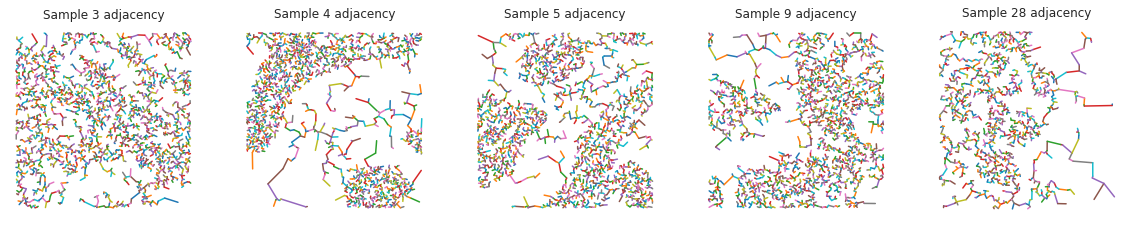

In [7]:
from spatial_lda.visualization import plot_adjacency_graph

def make_plot_fn(difference_matrices):  
    def plot_fn(ax, tumor_idx, features_df, patient_dfs):
        plot_adjacency_graph(ax, tumor_idx, features_df, patient_dfs, difference_matrices)
    return plot_fn
_plot_fn = make_plot_fn(train_difference_matrices)

plot_samples_in_a_row(train_tumor_marker_features, _plot_fn, patient_dfs, tumor_set=[3, 4, 5, 9, 28])

## Inspect the microenvironment data

In [8]:
tumor_marker_features

,Beta catenin,Ca,CD11b,CD11c,CD138,CD16,CD20,CD209,CD3,CD31,CD4,CD45,CD45RO,CD56,CD63,CD68,CD8,dsDNA,EGFR,Fe,FoxP3,H3K27me3,H3K9ac,HLA-DR,HLA_Class_1,IDO,Keratin17,Keratin6,Ki67,Lag3,MPO,Na,P,p53,Pan-Keratin,PD-L1,PD1,phospho-S6,Si,SMA,Ta,Vimentin
"(1, 0)",0,11,0,0,0,0,2,0,0,0,0,7,0,0,0,2,0,11,0,8,0,11,10,2,11,0,0,0,0,0,0,11,10,0,0,0,0,7,7,1,9,2
"(1, 2)",0,12,0,0,0,0,1,0,0,0,0,6,0,0,0,2,1,12,0,8,0,11,10,2,12,0,0,0,0,0,0,12,10,0,0,0,0,5,4,2,7,3
"(1, 4)",0,14,0,0,0,0,3,0,0,0,0,7,0,0,0,3,1,14,0,10,0,13,13,5,14,0,0,0,0,0,0,14,13,0,0,0,0,7,3,2,7,3
"(1, 5)",0,12,0,0,0,0,3,0,0,0,0,7,0,0,0,2,1,12,0,8,0,11,11,3,12,0,0,0,0,0,0,12,11,0,0,0,0,5,2,2,6,3
"(1, 6)",0,11,0,0,0,0,4,0,0,0,0,6,0,0,0,2,1,11,0,8,0,10,10,2,11,0,0,0,0,0,0,11,10,0,0,0,0,5,0,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(41, 4559)",0,10,0,0,0,0,0,0,0,0,0,3,2,0,0,0,1,10,0,10,0,9,0,0,10,0,0,0,0,0,0,10,10,0,0,0,0,0,8,0,4,5
"(41, 4560)",0,5,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,5,0,5,0,4,0,0,5,0,0,0,0,0,0,5,4,0,0,0,0,0,5,0,4,2
"(41, 4561)",0,10,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,10,0,10,0,8,0,0,10,0,0,0,0,0,0,10,9,0,0,0,0,0,9,0,6,7
"(41, 4563)",0,4,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,4,0,4,0,4,0,0,4,0,0,0,0,0,0,4,4,0,0,0,0,0,4,0,4,3


## Fit spatial-LDA model on the training set

In [9]:
path_to_train_model = '_'.join((f'{PATH_TO_MODELS}/tnbc_training',
                                f'penalty={DIFFERENCE_PENALTY}',
                                f'topics={N_TOPICS}',
                                f'trainfrac={TRAIN_SIZE_FRACTION}')) + '.pkl'

if os.path.exists(path_to_train_model):
  print('Loading existing model and inferred topics.')
  with open(path_to_train_model, 'rb') as f:
    spatial_lda_model = pickle.load(f)
else:
  spatial_lda_model = spatial_lda.model.train(train_tumor_marker_features, 
                                              train_difference_matrices, 
                                              n_topics=N_TOPICS, 
                                              difference_penalty=DIFFERENCE_PENALTY, 
                                              verbosity=1,
                                              n_parallel_processes=3,
                                              n_iters=3,
                                              admm_rho=0.1,
                                              primal_dual_mu=2)
  with open(path_to_train_model, 'wb') as f:
    pickle.dump(spatial_lda_model, f)

Loading existing model and inferred topics.


# Inference of topics for each neighborhood 


In [10]:
PATH_TO_COMPLETE_MODEL = '_'.join((f'{PATH_TO_MODELS}/tnbc_complete',
                                f'penalty={DIFFERENCE_PENALTY}',
                                f'topics={N_TOPICS}',
                                f'trainfrac={TRAIN_SIZE_FRACTION}')) + '.pkl'

if os.path.exists(PATH_TO_COMPLETE_MODEL):
  print('Loading existing model and inferred topics.')
  with open(PATH_TO_COMPLETE_MODEL, 'rb') as f:
    complete_lda = pickle.load(f)
else:
  complete_difference_matrices = make_merged_difference_matrices(
      tumor_marker_features, patient_dfs)
  complete_lda = spatial_lda.model.infer(
      spatial_lda_model.components_, tumor_marker_features, 
      complete_difference_matrices, difference_penalty=250,
      n_parallel_processes=N_PARALLEL_PROCESSES)
  with open(PATH_TO_COMPLETE_MODEL, 'wb') as f:
    pickle.dump(complete_lda, f)

Loading existing model and inferred topics.


# Visualization

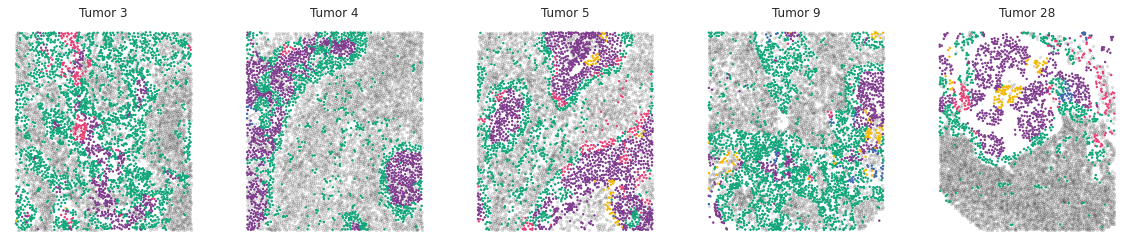

In [11]:
plot_samples_in_a_row(complete_lda.topic_weights, plot_one_tumor_all_topics, patient_dfs, tumor_set=[3, 4, 5, 9, 28])

In [12]:
for t in range(N_TOPICS):
  plot_samples_in_a_row(complete_lda.topic_weights.iloc[:, t], plot_one_tumor_topic, patient_dfs, tumor_set=[3, 4, 5, 9, 28])

Output hidden; open in https://colab.research.google.com to view.

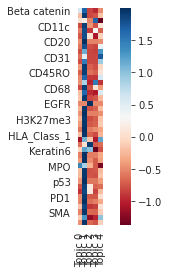

In [13]:
plot_topics_heatmap(complete_lda.components_, tumor_marker_features.columns)


# Survival analysis

In [14]:
with open(PATH_TO_COHORT_METADATA, 'rb') as f:
  tumor_metadata = pd.read_excel(f, header=1).iloc[:39]
tumor_metadata.index = tumor_metadata['InternalId'].astype(int)
tumor_metadata['event'] = tumor_metadata['Censored'] != 1.0
topic_weight_for_regression = complete_lda.topic_weights

topic_weight_for_regression['tumor_idx'] = topic_weight_for_regression.index.map(lambda x: x[0])

In [15]:
def threshold_x(x, values):
  return ((values > x).sum() + 1) / ((values <= x).sum() + 1)  

threshold_ = functools.partial(threshold_x, 0.2)
aggregate_measures = topic_weight_for_regression.groupby('tumor_idx').agg([np.mean, threshold_])
aggregate_measures.columns = ['%s (%s)' % (x, y) for x, y in aggregate_measures.columns]

In [16]:
def get_tumor_markers(tumor_features):
  tumor_idx = tumor_features.index.map(lambda x: x[0])
  tumor_set = np.unique(tumor_idx)
  num_rows = (len(tumor_set) // 4) + 1
  markers = []
  for i, tumor in enumerate(tumor_set):
    cell_idx = tumor_features[tumor_idx == tumor].index.map(lambda x: x[1])
    feature_df = patient_dfs[tumor].iloc[cell_idx]
    feature_df = feature_df.set_index(tumor_features[tumor_idx == tumor].index)
    markers.append(feature_df)
  markers = pd.concat(markers)
  return markers

In [17]:
marker_df = get_tumor_markers(complete_lda.topic_weights)
marker_df['tumor_idx'] = marker_df.index.map(lambda x: x[0])
threshold_ = functools.partial(threshold_x, 0.05)
aggregated_tumor_markers = marker_df.groupby('tumor_idx').agg([np.mean, threshold_])
aggregated_tumor_markers.columns = ['%s (%s)' % (x, y) for x, y in aggregated_tumor_markers.columns]

regression_data = pd.merge(aggregate_measures, tumor_metadata, left_index=True, right_index=True)
regression_data = pd.merge(regression_data, aggregated_tumor_markers, left_index=True, right_index=True)
regression_data['is_mixed'] = 1 - regression_data.index.isin(compartmentalized_tumors).astype(int)

Iteration 1: norm_delta = 1.51590, step_size = 0.9500, log_lik = -49.61757, newton_decrement = 4.79025, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.40380, step_size = 0.9500, log_lik = -45.60357, newton_decrement = 0.52142, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.17662, step_size = 0.9500, log_lik = -45.04911, newton_decrement = 0.04366, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.13023, step_size = 1.0000, log_lik = -44.99717, newton_decrement = 0.00903, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.07425, step_size = 1.0000, log_lik = -44.98635, newton_decrement = 0.00146, seconds_since_start = 0.0
Iteration 6: norm_delta = 0.01786, step_size = 1.0000, log_lik = -44.98472, newton_decrement = 0.00006, seconds_since_start = 0.0
Iteration 7: norm_delta = 0.00080, step_size = 1.0000, log_lik = -44.98466, newton_decrement = 0.00000, seconds_since_start = 0.0
Iteration 8: norm_delta = 0.00000, step_size = 1.0000, log_lik = -44.98466, newton_decreme

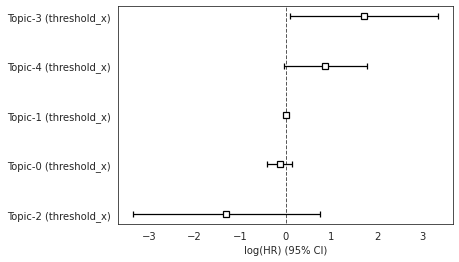

In [18]:
import lifelines
cph = lifelines.CoxPHFitter()
covariates = ['Survival_days_capped*', 'event'] + ['Topic-%d (threshold_x)' % i for i in range(5)]
cph.fit(regression_data[covariates], duration_col='Survival_days_capped*', event_col='event', show_progress=True)
cph.print_summary()
cph.plot()